In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import os

import ECM_p_function as ext 

# Running the algorithm 

In [ ]:



# Outpu
OUT_DIR = r"C:\Users\hhn54\OneDrive\Dokumenter\Speciale\Resultater"

# Monte carlo numbers and Nobs
Ns = [100, 500, 1000, 10000]
M  = 10

#TRUE PARAMETERS 
lambdas_true = np.array([2.0, 1.5, 1.2], dtype=float)   # example p=3
R_true = np.array([
    [0.70, 0.20, 0.10],
    [0.15, 0.70, 0.15],
    [0.10, 0.25, 0.65],
], dtype=float)

# Setting for running
MAX_ITER = 2000
MAX_R_INNER = 10
LL_TOL_PER_OBS = 1e-7
MIN_ITER = 5

# store per-iteration soft objective trajectory (long format)
SAVE_TRAJECTORY = True

# Ensure output folder exists
os.makedirs(OUT_DIR, exist_ok=True)



# Storage
rows_summary = []
rows_runs = []
rows_ll_traj = []



# Helper: monotonicity check (allow tiny numerical noise)
def is_monotone_nondecreasing(x, tol=1e-10):
    x = np.asarray(x, float)
    if x.size < 2:
        return True
    return bool(np.all(np.diff(x) >= -tol))


# --------------------
# Helper: map R -> u for row-wise softmax parameterization
# R_from_u_p uses row-wise softmax, so a compatible inverse is row-wise logits.
# --------------------
def u_from_R_p(R, eps=1e-300):
    R = np.asarray(R, dtype=float)
    if np.any(R <= 0):
        raise ValueError("R must be strictly positive to form logits for u.")
    U = np.log(np.clip(R, eps, None))
    # softmax is invariant to adding a constant per row; center to stabilize
    U = U - np.mean(U, axis=1, keepdims=True)
    return U.ravel()



# Basic checksto make sure it can run
lambdas_true = np.asarray(lambdas_true, float)
R_true = np.asarray(R_true, float)

p = int(lambdas_true.size)
if R_true.shape != (p, p):
    raise ValueError(f"R_true must be shape (p,p) with p={p}. Got {R_true.shape}.")

if np.any(lambdas_true <= 0) or (not np.all(np.isfinite(lambdas_true))):
    raise ValueError("All lambdas_true must be positive and finite.")

# Ensure R_true rows sum to 1
row_sums = R_true.sum(axis=1)
if not np.allclose(row_sums, 1.0, atol=1e-10):
    raise ValueError("Each row of R_true should sum to 1 for the row-wise softmax parameterization.")


# ============================================================
# Main loop
# ============================================================
for N in Ns:
    # For N-level summary
    true_ll_list = []
    est_ll_list  = []
    time_list    = []
    delta_po_list = []
    iters_list    = []
    mono_list     = []
    conv_list     = []
    feas_rate_list = []

    fit_ok = 0
    ll_ok  = 0

    for m in range(M):
        # random settings
        seed = 10_000 * m + N + 1234
        rng = np.random.default_rng(seed)

        # data simulation
        Z_all, Y = ext.simulate_kulkarni_p_dataset(lambdas_true, R_true, N=N, rng=rng)

        # inital conditions
        # Lambdas init: perturb true lambdas and clip to stay positive
        lambdas0 = lambdas_true + rng.normal(scale=0.3, size=p)
        lambdas0 = np.clip(lambdas0, 1e-6, None)

        # u init around true u (logits) with noise
        u0_true = u_from_R_p(R_true)
        u0 = u0_true + rng.normal(scale=0.3, size=p * p)

        # time
        t0 = time.perf_counter()
        try:
            lambdas_hat, R_hat, ll_hist_soft = ext.run_em_p(
                Y,
                lambdas0=lambdas0,
                u0=u0,
                max_iter=MAX_ITER,
                max_R_inner_steps=MAX_R_INNER,
                tol=ext.TOL_Z,
                det_tol=ext.DET_TOL,
                cond_max=ext.COND_MAX,
                penalty=ext.PENALTY_Z,
                power=ext.PENALTY_POW,
                ll_tol_per_obs=LL_TOL_PER_OBS,
                min_iter=MIN_ITER,
                verbose=False,
                track_ll=True,                 
                return_hard_diagnostic=False,  # soft objective is the tracked objective
            )
            t1 = time.perf_counter()
            fit_ok += 1
            fit_success = True
            fit_error = ""
        except RuntimeError as e:
            t1 = time.perf_counter()
            fit_success = False
            fit_error = str(e)

            rows_runs.append({
                "N": N,
                "m": m,
                "seed": seed,
                "fit_success": False,
                "fit_error": fit_error,
                "runtime_sec": t1 - t0,
                "p": p,
                **{f"lambda0_{k+1}": float(lambdas0[k]) for k in range(p)},
                **{f"u0_{j+1}": float(u0[j]) for j in range(p*p)},
                # no estimates
                **{f"lambda_hat_{k+1}": np.nan for k in range(p)},
                **{f"R_hat_{i+1}{j+1}": np.nan for i in range(p) for j in range(p)},
                "ll_true_soft": np.nan,
                "ll_est_soft": np.nan,
                "ll_true_soft_per_obs": np.nan,
                "ll_est_soft_per_obs": np.nan,
                "delta_ll_soft_per_obs": np.nan,
                "iters": np.nan,
                "ll_monotone": np.nan,
                "converged_flag": np.nan,
                "final_abs_dll_per_obs": np.nan,
                "feas_count_final": np.nan,
                "feas_rate_final": np.nan,
                "ll_hist_len": np.nan,
            })
            continue

        runtime = t1 - t0

        # evaluate likelihooda
        ll_true_m = ext.loglik_Y_p_soft(
            Y, lambdas_true, R_true,
            tol=ext.TOL_Z, det_tol=ext.DET_TOL, cond_max=ext.COND_MAX,
            penalty=ext.PENALTY_Z, power=ext.PENALTY_POW
        )
        ll_est_m = ext.loglik_Y_p_soft(
            Y, lambdas_hat, R_hat,
            tol=ext.TOL_Z, det_tol=ext.DET_TOL, cond_max=ext.COND_MAX,
            penalty=ext.PENALTY_Z, power=ext.PENALTY_POW
        )

        # Feasibility at final estimate (diagnostic)
        _, mask_final, feas_count_final = ext.feasibility_info(
            Y, R_hat, tol=ext.TOL_Z, det_tol=ext.DET_TOL, cond_max=ext.COND_MAX
        )
        feas_rate_final = float(feas_count_final) / float(N) if N > 0 else np.nan

        # If ll invalid, record and skip from N-level stats (but still save run)
        if not (np.isfinite(ll_true_m) and np.isfinite(ll_est_m)):
            rows_runs.append({
                "N": N,
                "m": m,
                "seed": seed,
                "fit_success": True,
                "fit_error": "",
                "runtime_sec": runtime,
                "p": p,
                **{f"lambda0_{k+1}": float(lambdas0[k]) for k in range(p)},
                **{f"u0_{j+1}": float(u0[j]) for j in range(p*p)},
                **{f"lambda_hat_{k+1}": float(lambdas_hat[k]) for k in range(p)},
                **{f"R_hat_{i+1}{j+1}": float(R_hat[i, j]) for i in range(p) for j in range(p)},
                "ll_true_soft": float(ll_true_m),
                "ll_est_soft": float(ll_est_m),
                "ll_true_soft_per_obs": float(ll_true_m) / N if np.isfinite(ll_true_m) else np.nan,
                "ll_est_soft_per_obs": float(ll_est_m) / N if np.isfinite(ll_est_m) else np.nan,
                "delta_ll_soft_per_obs": np.nan,
                "iters": int(len(ll_hist_soft)) if ll_hist_soft is not None else np.nan,
                "ll_monotone": np.nan,
                "converged_flag": np.nan,
                "final_abs_dll_per_obs": np.nan,
                "feas_count_final": int(feas_count_final),
                "feas_rate_final": float(feas_rate_final),
                "ll_hist_len": int(len(ll_hist_soft)) if ll_hist_soft is not None else np.nan,
            })
            continue

        ll_ok += 1

        #diagnostics from ll_hist_soft
        ll_hist_soft = np.asarray(ll_hist_soft, dtype=float)
        ll_hist_soft = ll_hist_soft[np.isfinite(ll_hist_soft)]
        iters = int(ll_hist_soft.size)

        ll_hist_po = ll_hist_soft / N if iters > 0 else np.array([], float)
        mono = is_monotone_nondecreasing(ll_hist_soft, tol=1e-10)

        if iters >= 2:
            final_abs_dll_po = float(abs(ll_hist_po[-1] - ll_hist_po[-2]))
        else:
            final_abs_dll_po = np.nan

        converged_flag = bool(
            (iters >= MIN_ITER)
            and np.isfinite(final_abs_dll_po)
            and (final_abs_dll_po <= LL_TOL_PER_OBS)
        )

        #save per-iteration trajectory (long format)
        if SAVE_TRAJECTORY and iters > 0:
            for k, llk in enumerate(ll_hist_po, start=1):
                rows_ll_traj.append({
                    "N": N,
                    "m": m,
                    "seed": seed,
                    "iter": k,
                    "ll_soft_per_obs": float(llk),
                })

        # per-run summary quantities
        ll_true_po = float(ll_true_m) / N
        ll_est_po  = float(ll_est_m)  / N
        delta_po   = ll_est_po - ll_true_po

        rows_runs.append({
            "N": N,
            "m": m,
            "seed": seed,
            "fit_success": True,
            "fit_error": "",
            "runtime_sec": runtime,
            "p": p,
            **{f"lambda0_{k+1}": float(lambdas0[k]) for k in range(p)},
            **{f"u0_{j+1}": float(u0[j]) for j in range(p*p)},
            **{f"lambda_hat_{k+1}": float(lambdas_hat[k]) for k in range(p)},
            **{f"R_hat_{i+1}{j+1}": float(R_hat[i, j]) for i in range(p) for j in range(p)},
            "ll_true_soft": float(ll_true_m),
            "ll_est_soft": float(ll_est_m),
            "ll_true_soft_per_obs": ll_true_po,
            "ll_est_soft_per_obs": ll_est_po,
            "delta_ll_soft_per_obs": float(delta_po),
            "iters": iters,
            "ll_monotone": mono,
            "converged_flag": converged_flag,
            "final_abs_dll_per_obs": final_abs_dll_po,
            "feas_count_final": int(feas_count_final),
            "feas_rate_final": float(feas_rate_final),
            "ll_hist_len": iters,
        })

        # For N-level summary
        time_list.append(runtime)
        true_ll_list.append(ll_true_m)
        est_ll_list.append(ll_est_m)
        delta_po_list.append(delta_po)
        iters_list.append(iters)
        mono_list.append(mono)
        conv_list.append(converged_flag)
        feas_rate_list.append(feas_rate_final)

    #N-level summary row
    true_ll_arr = np.asarray(true_ll_list, dtype=float)
    est_ll_arr  = np.asarray(est_ll_list, dtype=float)

    mean_true_ll = float(np.mean(true_ll_arr)) if true_ll_arr.size else np.nan
    mean_est_ll  = float(np.mean(est_ll_arr))  if est_ll_arr.size  else np.nan

    delta_po_arr = np.asarray(delta_po_list, dtype=float)
    delta_po_mean = float(np.mean(delta_po_arr)) if delta_po_arr.size else np.nan
    delta_po_sd   = float(np.std(delta_po_arr, ddof=1)) if delta_po_arr.size > 1 else np.nan

    mean_time_sec = float(np.mean(time_list)) if time_list else np.nan

    iters_arr = np.asarray(iters_list, dtype=float)
    iters_med = float(np.median(iters_arr)) if iters_arr.size else np.nan
    iters_p90 = float(np.quantile(iters_arr, 0.90)) if iters_arr.size else np.nan

    mono_rate = float(np.mean(mono_list)) if mono_list else np.nan
    conv_rate = float(np.mean(conv_list)) if conv_list else np.nan

    feas_rate_arr = np.asarray(feas_rate_list, dtype=float)
    feas_rate_mean = float(np.mean(feas_rate_arr)) if feas_rate_arr.size else np.nan
    feas_rate_sd   = float(np.std(feas_rate_arr, ddof=1)) if feas_rate_arr.size > 1 else np.nan

    rows_summary.append({
        "N": N,
        "p": p,
        "True_logLik_soft_mean": mean_true_ll,
        "Est_logLik_soft_mean":  mean_est_ll,
        "delta_ll_soft_per_obs_mean": delta_po_mean,
        "delta_ll_soft_per_obs_sd":   delta_po_sd,
        "mean_time_sec": mean_time_sec,
        "fit_ok": int(fit_ok),   # ECM returned without runtime error
        "ll_ok":  int(ll_ok),    # finite ll_true and ll_est
        "conv_rate": conv_rate,
        "mono_rate": mono_rate,
        "iters_median": iters_med,
        "iters_p90": iters_p90,
        "feas_rate_mean": feas_rate_mean,
        "feas_rate_sd": feas_rate_sd,
    })


# Build DF
df_summary = pd.DataFrame(rows_summary)
df_runs    = pd.DataFrame(rows_runs)
df_ll_traj = pd.DataFrame(rows_ll_traj) if rows_ll_traj else pd.DataFrame()



# Save
summary_path = os.path.join(OUT_DIR, "kulkarni_p_ecm_summary_diagnostics.csv")
runs_path    = os.path.join(OUT_DIR, "kulkarni_p_ecm_runs_diagnostics.csv")
traj_path    = os.path.join(OUT_DIR, "kulkarni_p_ecm_llsoft_trajectory_long.csv")

df_summary.to_csv(summary_path, index=False)
df_runs.to_csv(runs_path, index=False)
if not df_ll_traj.empty:
    df_ll_traj.to_csv(traj_path, index=False)

df_summary


,N,p,True_logLik_soft_mean,Est_logLik_soft_mean,delta_ll_soft_per_obs_mean,delta_ll_soft_per_obs_sd,mean_time_sec,fit_ok,ll_ok,conv_rate,mono_rate,iters_median,iters_p90,feas_rate_mean,feas_rate_sd
0,100,3,-38.204320,-33.731554,0.044728,0.049408,34.611808,10,10,1.0,0.1,218.5,742.5,0.95200,0.011353
1,500,3,-190.841861,-187.565858,0.006552,0.025882,372.027767,10,10,1.0,0.5,458.0,1230.1,0.98760,0.002633
2,1000,3,-454.718495,-445.457790,0.009261,0.001792,785.586800,10,10,1.0,0.4,369.5,802.9,0.99300,0.001333
3,10000,3,-4209.120676,-4186.228628,0.002289,0.000507,3514.790354,10,10,1.0,0.5,134.5,669.4,0.99694,0.000488


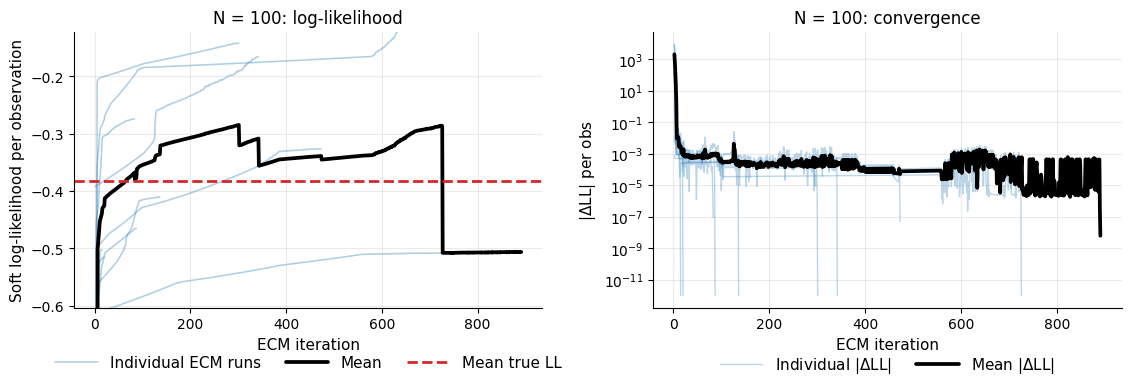

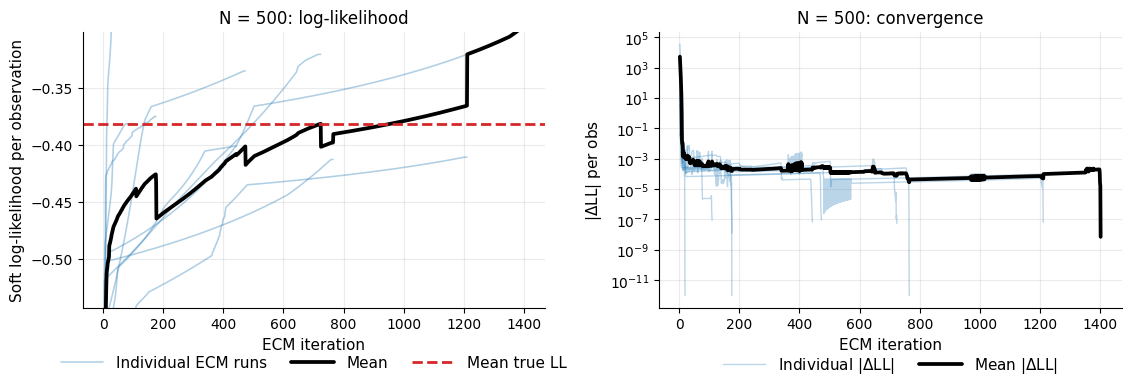

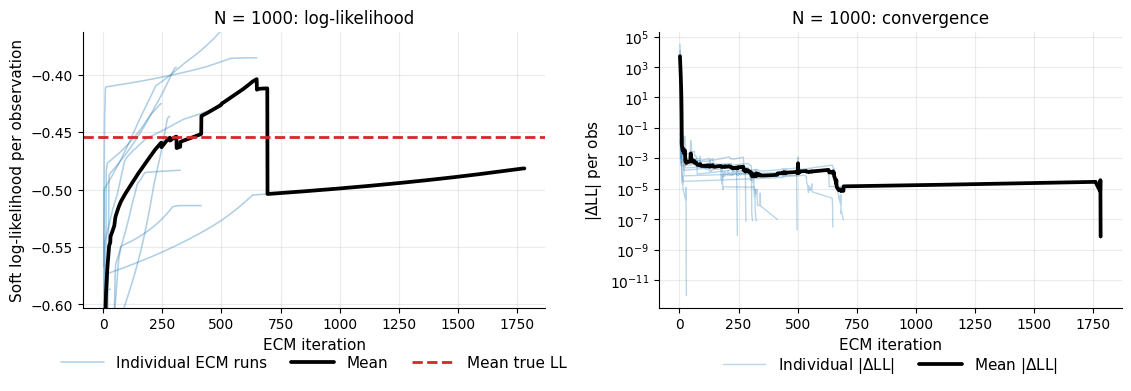

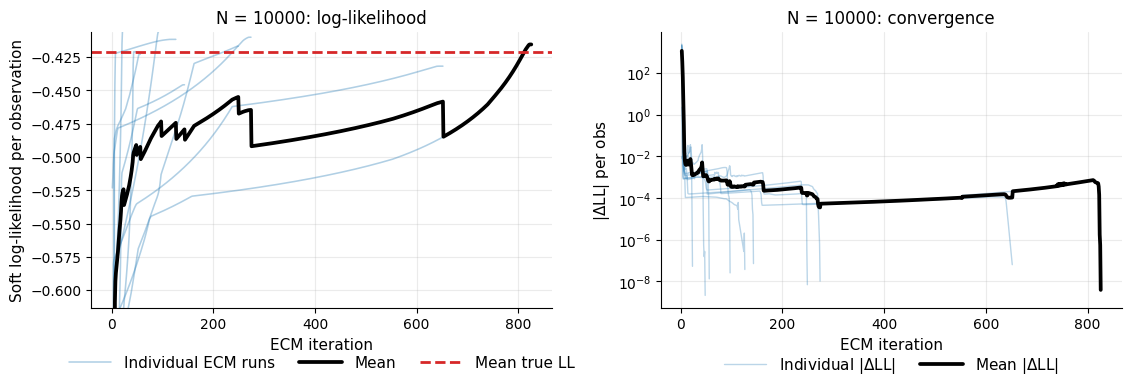

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl


def pad_runs_to_matrix(runs):
    """Pad variable-length runs into a 2D matrix with NaNs."""
    if not runs:
        return np.empty((0, 0))
    L = max(len(r) for r in runs)
    M = np.full((len(runs), L), np.nan, dtype=float)
    for i, r in enumerate(runs):
        rr = np.asarray(r, dtype=float)
        rr = rr[np.isfinite(rr)]
        M[i, : len(rr)] = rr
    return M


def ll_hists_from_long_df(df_ll_traj, Ns, value_col="ll_soft_per_obs"):
    """
    Build ll_hists_all = {N: [run1_list, run2_list, ...]} from a long-format DF.

    Required columns: N, m, iter, value_col (default "ll_soft_per_obs").
    """
    required = {"N", "m", "iter", value_col}
    missing = required - set(df_ll_traj.columns)
    if missing:
        raise ValueError(f"df_ll_traj missing columns: {sorted(missing)}")

    ll_hists_all = {}
    for N in Ns:
        subN = df_ll_traj.loc[df_ll_traj["N"] == N]
        runs = []
        if not subN.empty:
            for m, subm in subN.groupby("m", sort=True):
                subm = subm.sort_values("iter")
                vals = subm[value_col].to_numpy(dtype=float)
                vals = vals[np.isfinite(vals)]
                if vals.size:
                    runs.append(vals.tolist())
        ll_hists_all[N] = runs

    return ll_hists_all


def plot_two_panel_per_N_soft_per_obs(
    ll_hists_all,
    Ns,
    df_summary,

    runs_are_per_obs=True,     # True if ll_hists_all already stores per-observation LL
    # scaling / central tendency
    per_obs=True,              # keep True to label y-axis "per observation"
    central="mean",            # "mean" or "median"
    # styling
    run_color="tab:blue",
    run_alpha=0.35,
    run_lw=1.15,
    central_color="black",
    central_lw=2.7,
    ref_color="tab:red",
    ref_lw=2.0,
    grid_alpha=0.25,
    # readability of LL panel
    clip_ll_y=True,
    yclip=(5, 95),
    # convergence panel
    eps=1e-12,
    # export
    out_dir=r"C:\Users\hhn54\OneDrive\Dokumenter\Speciale\Figurer\Multivariate_Known_CTMC_pstates",
    file_prefix="ECM_pstates_soft",
    ref_col="True_logLik_soft_mean",
):
    """
    Two-panel plot per N:
      Left: LL trajectories (per obs if per_obs=True)
      Right: |ΔLL| trajectories (per obs if per_obs=True) on log scale

    IMPORTANT:
      - df_summary[ref_col] in your experiment is TOTAL LL (not per obs).
      - If ll_hists_all is built from df_ll_traj["ll_soft_per_obs"], then runs_are_per_obs must be True.
      - If ll_hists_all is built from raw ll_hist_soft (total), then runs_are_per_obs must be False.
    """

    os.makedirs(out_dir, exist_ok=True)

    mpl.rcParams.update({
        "font.size": 11,
        "axes.titlesize": 12,
        "axes.labelsize": 11,
        "xtick.labelsize": 10,
        "ytick.labelsize": 10,
        "axes.linewidth": 0.8,
        "lines.solid_capstyle": "round",
        "savefig.dpi": 400,
    })

    if "N" not in df_summary.columns:
        raise ValueError("df_summary must contain an 'N' column.")
    if ref_col not in df_summary.columns:
        raise ValueError(f"df_summary must contain '{ref_col}' (got: {list(df_summary.columns)})")

    Ns_sorted = sorted([N for N in Ns if len(ll_hists_all.get(N, [])) > 0])
    if not Ns_sorted:
        raise RuntimeError("No likelihood histories found in ll_hists_all.")

    for N in Ns_sorted:
        runs = ll_hists_all.get(N, [])
        if not runs:
            continue

        row = df_summary.loc[df_summary["N"] == N]
        if row.empty:
            raise RuntimeError(f"df_summary missing row for N={N}.")

        ref_total = float(row[ref_col].values[0])
        if not np.isfinite(ref_total):
            raise RuntimeError(f"Reference df_summary['{ref_col}'] not finite for N={N}.")

        # Scaling logic
        # We want per-observation plots if per_obs=True.
        if per_obs:
            # Reference is total => always convert to per obs
            ref = ref_total / N

            # Runs: if already per obs, do not divide again
            scale_runs = 1.0 if runs_are_per_obs else (1.0 / N)
        else:
            # Total scale plots
            ref = ref_total
            scale_runs = 1.0 if (not runs_are_per_obs) else float(N)

        # Matrix of LL paths (padded)
        M_ll = pad_runs_to_matrix(runs) * scale_runs

        # Central curve (LL)
        if central.lower() == "median":
            center_ll = np.nanmedian(M_ll, axis=0)
            center_label = "Median"
        else:
            center_ll = np.nanmean(M_ll, axis=0)
            center_label = "Mean"

        itc = np.arange(1, len(center_ll) + 1)

        # ---------------- Figure: 1x2 ----------------
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(11.2, 3.8), constrained_layout=True)

        #Left panel: soft log-likelihood trajectories 
        all_vals = []
        for j, r in enumerate(runs):
            rr = np.asarray(r, float)
            rr = rr[np.isfinite(rr)]
            if rr.size == 0:
                continue
            rr = rr * scale_runs
            it = np.arange(1, rr.size + 1)
            ax1.plot(
                it, rr,
                color=run_color, alpha=run_alpha, linewidth=run_lw,
                label="Individual ECM runs" if j == 0 else None
            )
            all_vals.append(rr)

        ax1.plot(itc, center_ll, color=central_color, linewidth=central_lw, label=center_label)
        ax1.axhline(ref, color=ref_color, linestyle="--", linewidth=ref_lw, label="Mean true LL")

        ax1.set_title(f"N = {N}: log-likelihood")
        ax1.set_xlabel("ECM iteration")
        ax1.set_ylabel("Soft log-likelihood per observation" if per_obs else "Soft log-likelihood")
        ax1.grid(True, alpha=grid_alpha)
        ax1.spines["top"].set_visible(False)
        ax1.spines["right"].set_visible(False)

        ax1.legend(
            frameon=False,
            loc="upper center",
            bbox_to_anchor=(0.5, -0.12),
            ncol=3,
            handlelength=2.8,
            columnspacing=1.6
        )

        if clip_ll_y and all_vals:
            vv = np.concatenate(all_vals)
            vv = vv[np.isfinite(vv)]
            if vv.size:
                lo, hi = np.percentile(vv, yclip)
                lo = min(lo, ref)
                hi = max(hi, ref)
                pad = 0.06 * (hi - lo) if hi > lo else 1.0
                ax1.set_ylim(lo - pad, hi + pad)

        # ===== Right panel: convergence diagnostic (|ΔLL|) =====
        for j, r in enumerate(runs):
            rr = np.asarray(r, float)
            rr = rr[np.isfinite(rr)]
            if rr.size < 2:
                continue
            rr = rr * scale_runs
            d = np.abs(np.diff(rr))
            it = np.arange(2, rr.size + 1)
            ax2.semilogy(
                it, np.maximum(d, eps),
                color=run_color, alpha=0.30, linewidth=1.0,
                label=r"Individual $|\Delta \mathrm{LL}|$" if j == 0 else None
            )

        # Central curve for |ΔLL|
        if M_ll.shape[1] >= 2:
            dM = np.abs(np.diff(M_ll, axis=1))
            if central.lower() == "median":
                center_d = np.nanmedian(dM, axis=0)
                d_label = r"Median $|\Delta \mathrm{LL}|$"
            else:
                center_d = np.nanmean(dM, axis=0)
                d_label = r"Mean $|\Delta \mathrm{LL}|$"

            itc_d = np.arange(2, len(center_d) + 2)
            ax2.semilogy(
                itc_d, np.maximum(center_d, eps),
                color=central_color, linewidth=central_lw, label=d_label
            )

        ax2.set_title(f"N = {N}: convergence")
        ax2.set_xlabel("ECM iteration")
        ax2.set_ylabel(r"$|\Delta \mathrm{LL}|$ per obs" if per_obs else r"$|\Delta \mathrm{LL}|$")
        ax2.grid(True, which="both", alpha=grid_alpha)
        ax2.spines["top"].set_visible(False)
        ax2.spines["right"].set_visible(False)

        ax2.legend(
            frameon=False,
            loc="upper center",
            bbox_to_anchor=(0.5, -0.12),
            ncol=2,
            handlelength=2.8,
            columnspacing=1.6
        )

        # -------- Save --------
        pdf_path = os.path.join(out_dir, f"{file_prefix}_N{N}_two_panel.pdf")
        png_path = os.path.join(out_dir, f"{file_prefix}_N{N}_two_panel.png")
        fig.savefig(pdf_path, bbox_inches="tight")
        fig.savefig(png_path, bbox_inches="tight", dpi=400)

        plt.show()



ll_hists_all = ll_hists_from_long_df(df_ll_traj, Ns, value_col="ll_soft_per_obs")

plot_two_panel_per_N_soft_per_obs(
    ll_hists_all=ll_hists_all,
    Ns=Ns,
    df_summary=df_summary,
    runs_are_per_obs=True,     # because df_ll_traj stores per-obs trajectories
    per_obs=True,
    central="mean",
    out_dir=r"C:\Users\hhn54\OneDrive\Dokumenter\Speciale\Figurer\Multivariate_Known_CTMC_pstates",
    file_prefix="ECM_pstates_soft",
    clip_ll_y=True,
    yclip=(5, 95),
    ref_col="True_logLik_soft_mean",
)
